In [1]:
import tensorflow as tf

import os
import math
import numpy as np
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from einops import rearrange, reduce
import sys
sys.path.insert(0, '/datadrive/AACS2023')
from fdf256dataset import FDF256Dataset

2023-04-21 08:15:47.805686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 08:15:48.601808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Could not load pyspng. Defaulting to pillow image backend.


In [2]:
dataset_path = '/datadrive/FDF/dataset/val'
dataset = FDF256Dataset(dirpath=dataset_path, load_keypoints=True, transform=None)

Dataset loaded from: /datadrive/FDF/dataset/val. Number of samples:6531


In [3]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=22,
                            prefetch_factor=2, persistent_workers=True, pin_memory=True)

/datadrive/anaconda3/envs/facediffusion/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


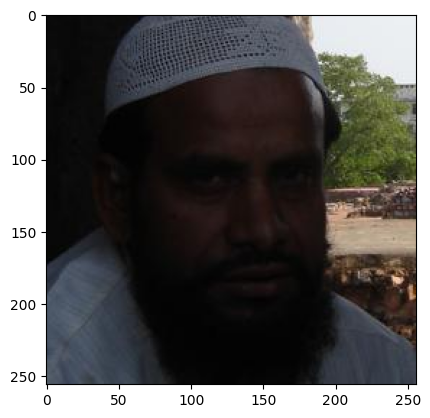

In [4]:
image = next(iter(dataloader))
plt.imshow(image['img'][0])

In [5]:
image['img'].shape

torch.Size([1, 256, 256, 3])

In [6]:
import torch
torch.squeeze(image['img']).shape

torch.Size([256, 256, 3])

In [7]:
import torchvision.transforms as T
import torch
from einops import rearrange

im = reduce(image['img'], "1 h w c -> c h w", 'max')

transform = T.ToPILImage()
image = transform(im)

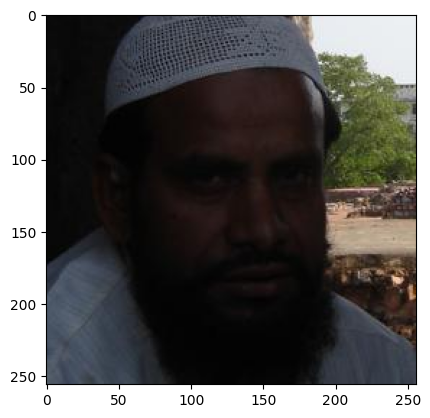

In [8]:
plt.imshow(image)

In [9]:
im.shape

torch.Size([3, 256, 256])

In [10]:
sys.path.append('/datadrive/AACS2023/ESPCN')
import ESPCN

2023-04-21 08:15:52.655741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-04-21 08:15:52.655787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: morvayb001
2023-04-21 08:15:52.655808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: morvayb001
2023-04-21 08:15:52.655889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.41.3
2023-04-21 08:15:52.655917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-04-21 08:15:52.655924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 530.30.2 does not match DSO version 530.41.3 -- cannot find working devices in this configuration


1/1 [==============================] - 0s 120ms/step
PSNR of low resolution image and high resolution image is 28.9028
PSNR of predict and high resolution is 29.4529
SSIM of low resolution image and high resolution image is 0.8509
SSIM of predict and high resolution is 0.8590
Avg. PSNR of lowres images is 28.9028
Avg. PSNR of reconstructions is 29.4529
Avg. SSIM of lowres images is 0.8509
Avg. SSIM of reconstructions is 0.8590


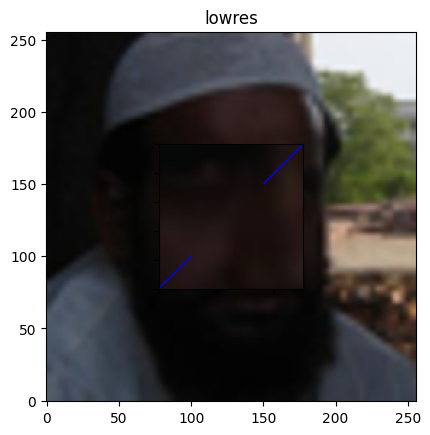

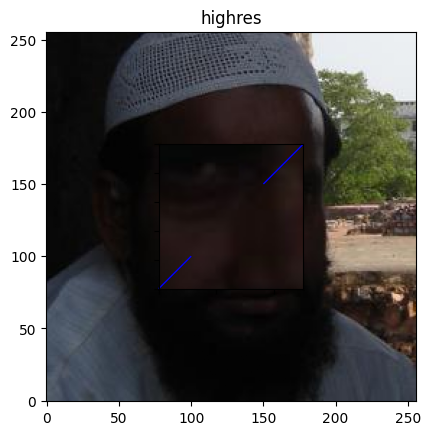

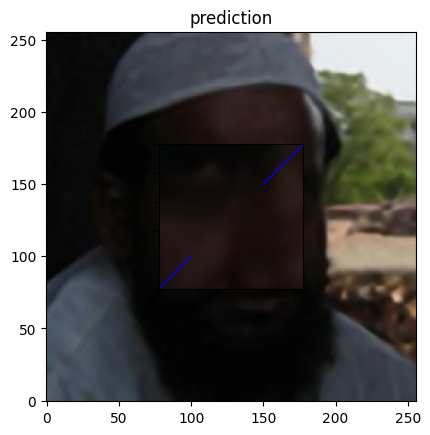

In [11]:
from ESPCN.ESPCN import run_model
run_model(model_path="/datadrive/AACS2023/ESPCN+FDF256/ESPCN+FDF_model", images=[image])

In [12]:
# Run the entire dataset through the network
from tqdm import tqdm

images = []

for i in tqdm(range(len(dataset))):
    image = dataset[i]["img"]
    transform = T.ToPILImage()
    image = transform(image)
    images.append(image)
    
average_bicubic_psnr, average_test_psnr, average_bicubic_ssim, average_test_ssim = run_model(model_path="/datadrive/AACS2023/ESPCN+FDF256/ESPCN+FDF_model", images=images, experimental=False)

print(f'Avg. PSNR of lowres images is {average_bicubic_psnr}, Avg. PSNR of reconstructions is {average_test_psnr}')
print(f'Avg. SSIM of lowres images is {average_bicubic_ssim}, Avg. SSIM of reconstructions is {average_test_ssim}')

100%|██████████| 6531/6531 [00:24<00:00, 266.15it/s]


1/1 [==============================] - 0s 22ms/step
Avg. PSNR of lowres images is 30.253074645996094, Avg. PSNR of reconstructions is 31.89373207092285
Avg. SSIM of lowres images is 0.8651707516687969, Avg. SSIM of reconstructions is 0.8946745657771165
